In [2]:
import os

def save_model(model, model_name):
    """
    Save the trained model to a file in the 'saved_models' folder.
    
    Args:
    model (torch.nn.Module): The model to be saved
    model_name (str): The desired name for the model file (without extension)
    """
    # Create the 'saved_models' directory if it doesn't exist
    save_dir = 'saved_models'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create the full path for the model file
    file_path = os.path.join(save_dir, f"{model_name}.pth")
    
    # Save the model
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

def load_model(model, model_name):
    """
    Load a trained model from a file in the 'saved_models' folder.
    
    Args:
    model (torch.nn.Module): An instance of the model architecture
    model_name (str): The name of the model file to load (without extension)
    
    Returns:
    torch.nn.Module: The loaded model
    """
    # Construct the full path to the model file
    file_path = os.path.join('saved_models', f"{model_name}.pth")
    
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No model file found at {file_path}")
    
    # Load the model
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import WeightedRandomSampler

In [7]:
# 1. Define the Neural Network
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Data Loading and Augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# 3. Implement Weighted Sampling for Class Imbalance
class_weights = [1.0] * 10  # Adjust these weights if needed
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

class_sample_count = torch.tensor(
    [(train_dataset.targets == t).sum() for t in range(10)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in train_dataset.targets])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


#train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. Define Model, Optimizer, and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(init_weights)

# 5. Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

#criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
criterion = nn.CrossEntropyLoss()

# 6. Training Loop with Curriculum Learning
def add_noise(images, noise_level):
    return images + noise_level * torch.randn_like(images)

def train(epochs):
    for epoch in range(epochs):
        model.train()
        pred_distribution = torch.zeros(10)
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Add gradient clipping here
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            _, predicted = torch.max(output.data, 1)
            pred_distribution += torch.bincount(predicted, minlength=10)
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                print(f'Prediction distribution: {pred_distribution}')
        
        print(f'Epoch {epoch} prediction distribution: {pred_distribution}')
        evaluate()
        scheduler.step(loss)  # If using LR scheduler
    save_model(model)

# 7. Evaluation Function
def evaluate():
    model.eval()
    correct = 0
    total = 0
    all_probabilities = []
    true_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)
            
            # For AUROC calculation
            all_probabilities.extend(probabilities.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    
    accuracy = 100 * correct / total
    all_probabilities = np.array(all_probabilities)
    true_labels = np.array(true_labels)
    
    # Calculate AUROC for each class
    auroc_scores = []
    for class_idx in range(10):  # Assuming 10 classes for MNIST
        class_true_labels = (true_labels == class_idx).astype(int)
        class_probabilities = all_probabilities[:, class_idx]
        auroc_scores.append(roc_auc_score(class_true_labels, class_probabilities))
    
    # Calculate average AUROC
    average_auroc = np.mean(auroc_scores)
    
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average AUROC: {average_auroc:.4f}')

# 8. Run Training
#train(epochs=20)

This implementation incorporates several of the suggested techniques:
Data Augmentation: We use random rotation and affine transformations.
Label Smoothing: Implemented as a custom loss function.
Curriculum Learning: We gradually increase noise during training.
Ensemble Methods: While not explicitly implemented, the dropout layer in the model can be seen as an implicit form of ensembling.
Noise-Aware Training: We add noise to the input images during training.
Metric Adjustment: We calculate both accuracy and AUROC for evaluation.
Class Imbalance: We use WeightedRandomSampler to handle potential class imbalance.
Confidence Calibration: Label smoothing helps with this.
To further improve this implementation, you could:
Implement Focal Loss instead of Label Smoothing Loss.
Add more aggressive data augmentation techniques.
Implement an explicit ensemble of multiple models.
Add a confidence threshold for abstaining from low-confidence predictions.
Remember to adjust hyperparameters (learning rate, noise levels, etc.) based on your specific dataset and requirements. This implementation provides a solid foundation for handling noisy digit classification while incorporating many of the suggested techniques.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score

# Define the model
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 2 * 2, 256)  # Adjusted for 16x16 input
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation function
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.cpu().numpy())
            # Convert logits to probabilities
            probabilities = F.softmax(output, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Calculate AUROC
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)
    auroc = roc_auc_score(all_targets, all_probabilities, multi_class='ovr', average='macro')

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    print(f'AUROC: {auroc:.4f}')
    return accuracy, auroc

# Training loop
num_epochs = 20
best_accuracy = 0

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v4.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training complete')

In [14]:
save_model(model, 'skeptic_v3')

Model saved to saved_models\skeptic_v3.pth


In [ ]:
# After training, you can load and evaluate the model like this:
loaded_model = NoisyDigitClassifier().to(device)
loaded_model = load_model(loaded_model)

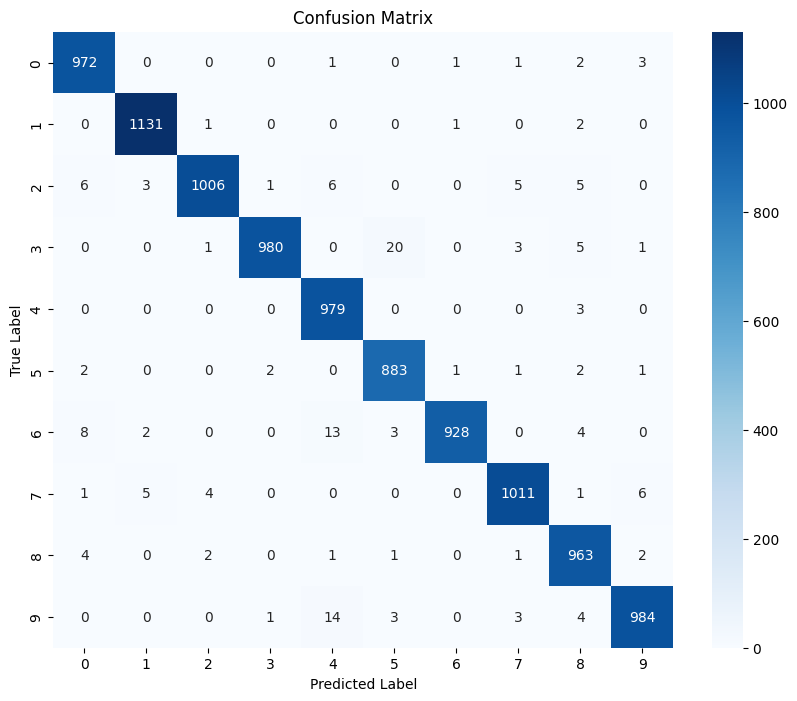

Accuracy: 98.37%
Average AUROC: 0.9998
Class 0 Accuracy: 99.18%
Class 1 Accuracy: 99.65%
Class 2 Accuracy: 97.48%
Class 3 Accuracy: 97.03%
Class 4 Accuracy: 99.69%
Class 5 Accuracy: 98.99%
Class 6 Accuracy: 96.87%
Class 7 Accuracy: 98.35%
Class 8 Accuracy: 98.87%
Class 9 Accuracy: 97.52%
Most predicted class: 1


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_matrix():
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * np.mean(np.array(all_predictions) == np.array(all_targets))
    
    # Calculate AUROC
    all_probabilities = np.array(all_probabilities)
    all_targets = np.array(all_targets)
    auroc_scores = []
    for class_idx in range(10):  # 10 classes for MNIST
        class_true_labels = (all_targets == class_idx).astype(int)
        class_probabilities = all_probabilities[:, class_idx]
        auroc_scores.append(roc_auc_score(class_true_labels, class_probabilities))
    average_auroc = np.mean(auroc_scores)
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average AUROC: {average_auroc:.4f}')
    
    # Print class-wise accuracy
    for i in range(10):
        class_accuracy = 100 * cm[i, i] / np.sum(cm[i])
        print(f'Class {i} Accuracy: {class_accuracy:.2f}%')
    
    # Find the most predicted class
    most_predicted_class = np.argmax(np.sum(cm, axis=0))
    print(f'Most predicted class: {most_predicted_class}')

# Call evaluate function after training
evaluate_matrix()

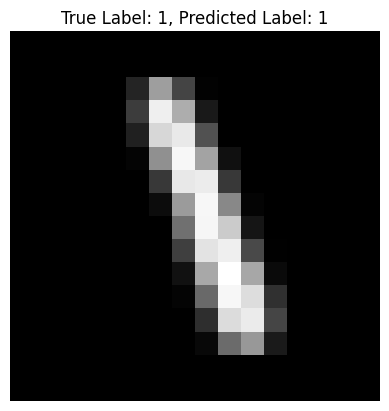

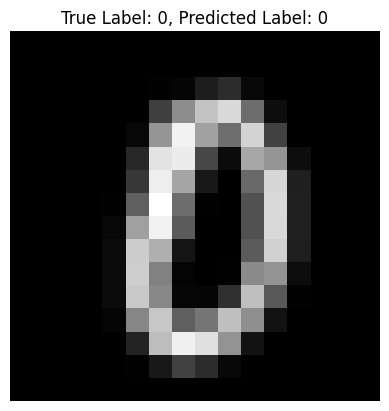

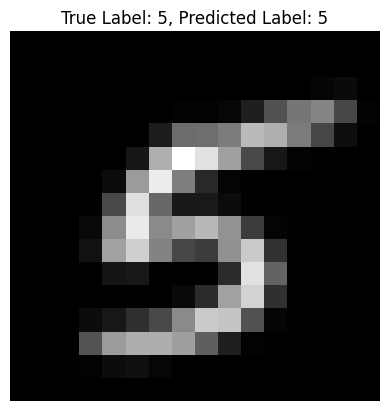

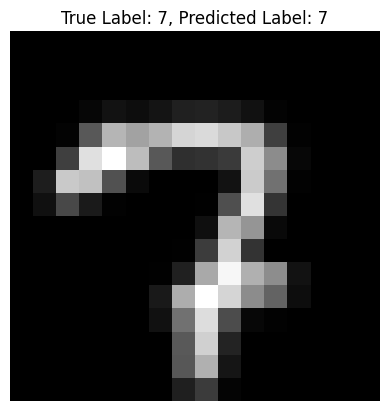

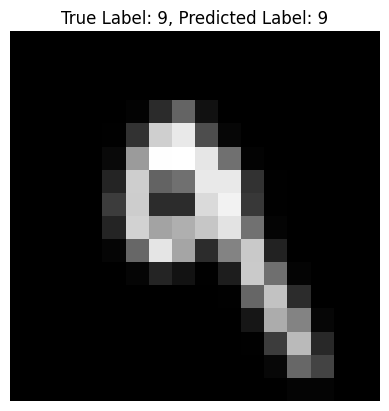

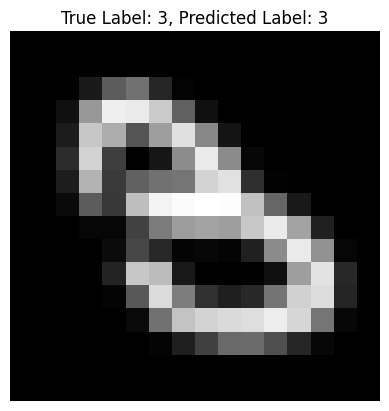

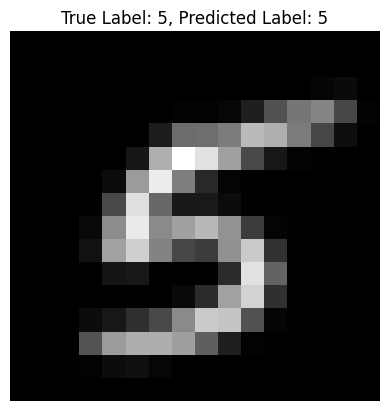

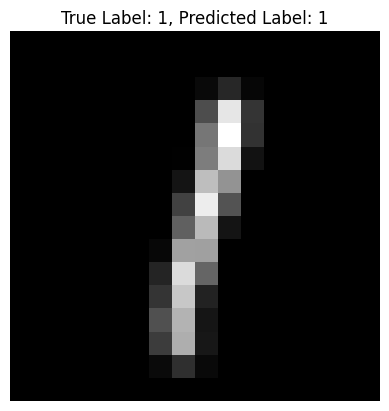

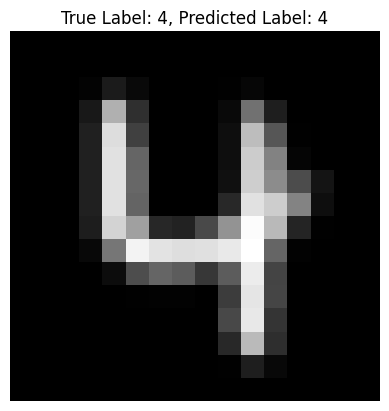

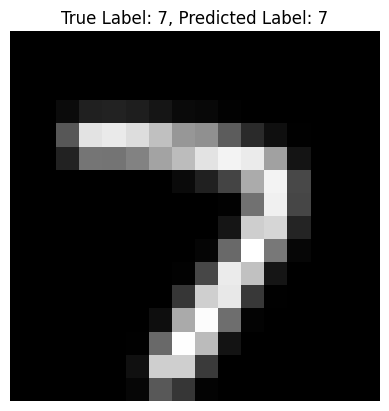

In [14]:
#I am very suspicious of these results - let's check the model's predictions on some random images from the test set.
import matplotlib.pyplot as plt

def visualize_predictions():
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(10):
                idx = np.random.randint(0, data.size(0))
                image = data[idx].cpu().numpy().squeeze()
                plt.imshow(image, cmap='gray')
                plt.axis('off')
                plt.title(f'True Label: {target[idx]}, Predicted Label: {predicted[idx]}')
                plt.show()
                if i == 9:
                    break
            break

visualize_predictions()

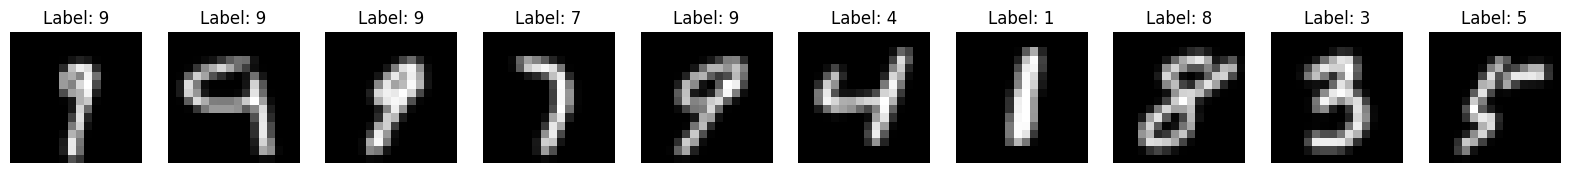

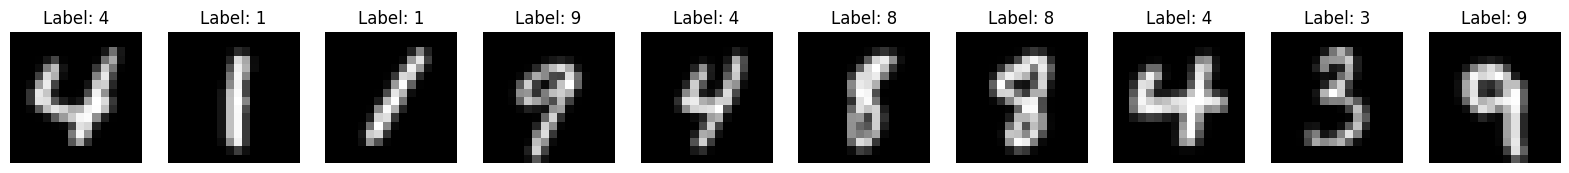

In [21]:
#let's inspect a small sample of the models training and test data
def visualize_dataset(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

visualize_dataset(train_dataset)
visualize_dataset(test_dataset)

In [25]:
#this might be a silly thought, but perhaps the model is confused because it was trained to recognise white letters on a black background but our data follows the opposite strucutre
#let's invert the colors of the images and retrain the model

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v5.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training complete')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305584
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.294460
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.132340
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.074528
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.049305
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.060764
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.080047
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.052905
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.031956
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.134984

Test set: Average loss: 0.0008, Accuracy: 9846/10000 (98.46%)
AUROC: 0.9999
Model saved with accuracy: 98.46%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.079032
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.078229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.073240
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.014228
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029783
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.003730
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.017355
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.060110
T

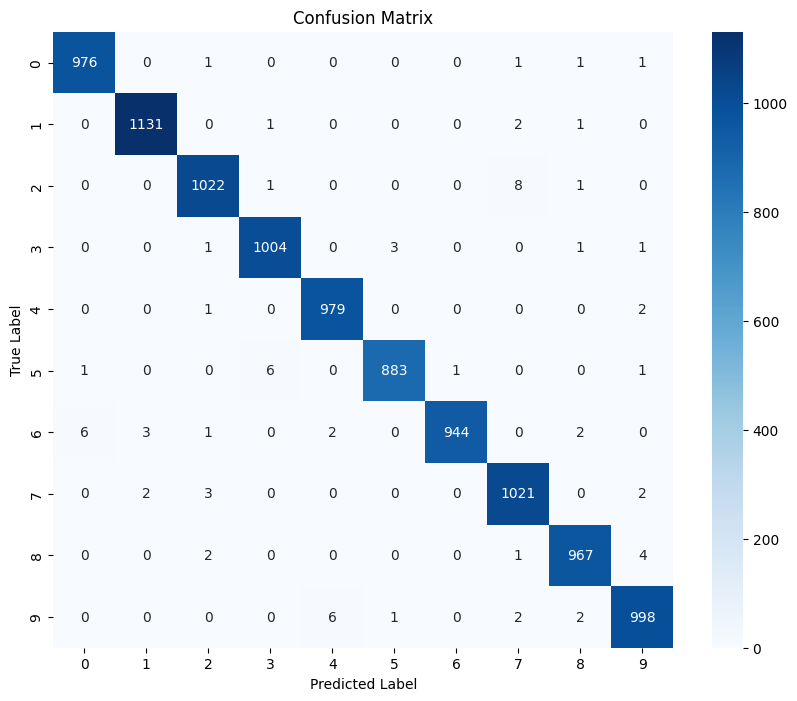

Accuracy: 99.25%
Average AUROC: 1.0000
Class 0 Accuracy: 99.59%
Class 1 Accuracy: 99.65%
Class 2 Accuracy: 99.03%
Class 3 Accuracy: 99.41%
Class 4 Accuracy: 99.69%
Class 5 Accuracy: 98.99%
Class 6 Accuracy: 98.54%
Class 7 Accuracy: 99.32%
Class 8 Accuracy: 99.28%
Class 9 Accuracy: 98.91%
Most predicted class: 1


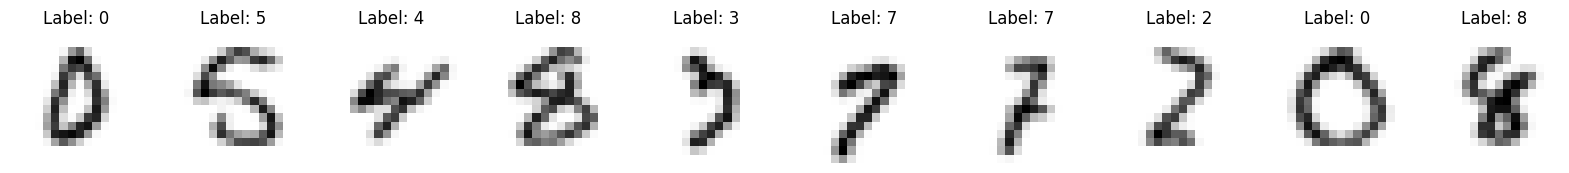

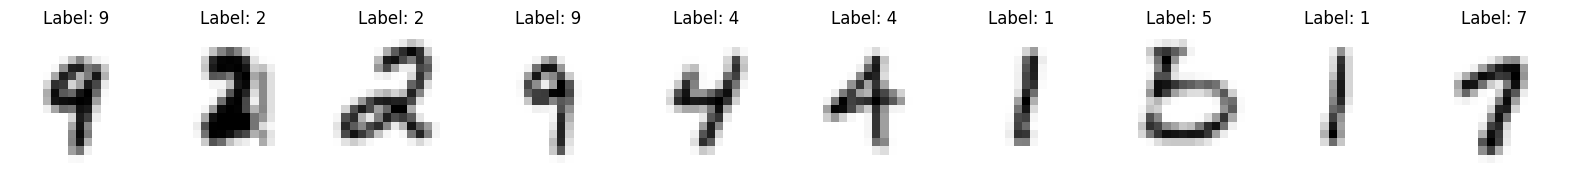

In [26]:
evaluate_matrix()
visualize_dataset(train_dataset)
visualize_dataset(test_dataset)

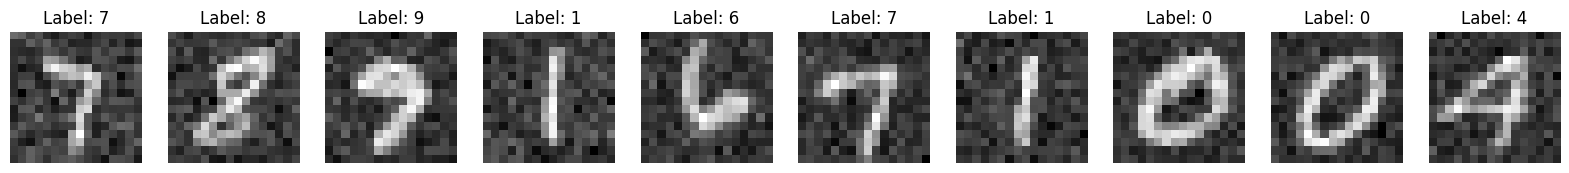

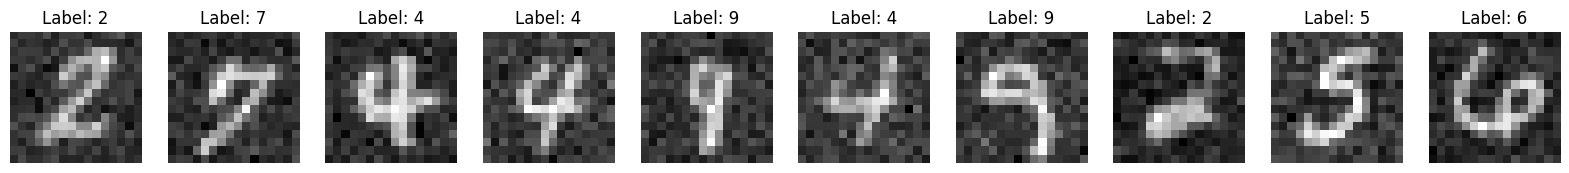

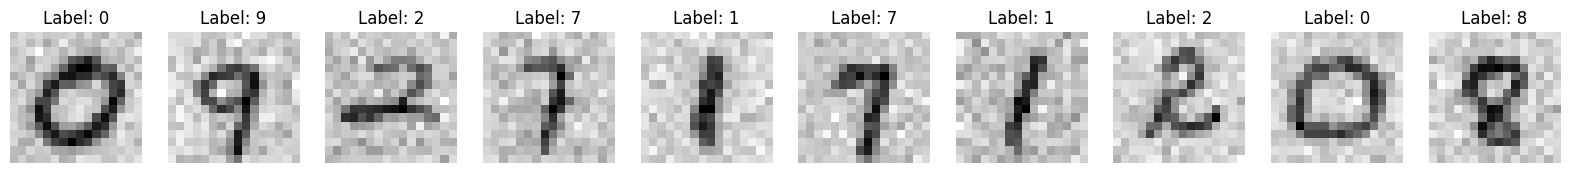

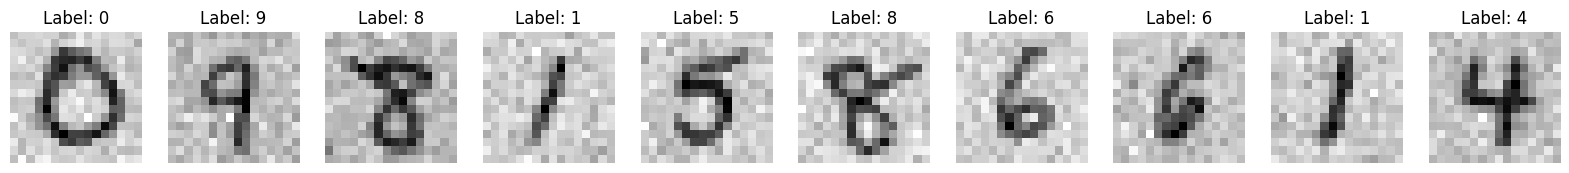

In [28]:
#this has marginally improved the model's performance on real data - but not by much - let's try train the model with data that has been transformed such that we add grayscaled noise to the images

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Add noise
    transforms.Normalize((0.1307,), (0.3081,))
])

#lets visualise the transformed data before training
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

visualize_dataset(train_dataset)
visualize_dataset(test_dataset)

#we forgot to invert the colours
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Add noise
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

visualize_dataset(train_dataset)
visualize_dataset(test_dataset)


In [29]:
#now we should be able to retrain the model

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Add noise
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v6.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training complete')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355000
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.248184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.127677
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.105083
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.395803
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.044277
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.055374
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.119525
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.059010
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.043837

Test set: Average loss: 0.0010, Accuracy: 9789/10000 (97.89%)
AUROC: 0.9997
Model saved with accuracy: 97.89%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.075229
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.019427
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.131899
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.191356
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116282
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.034883
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.050297
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.066929
T

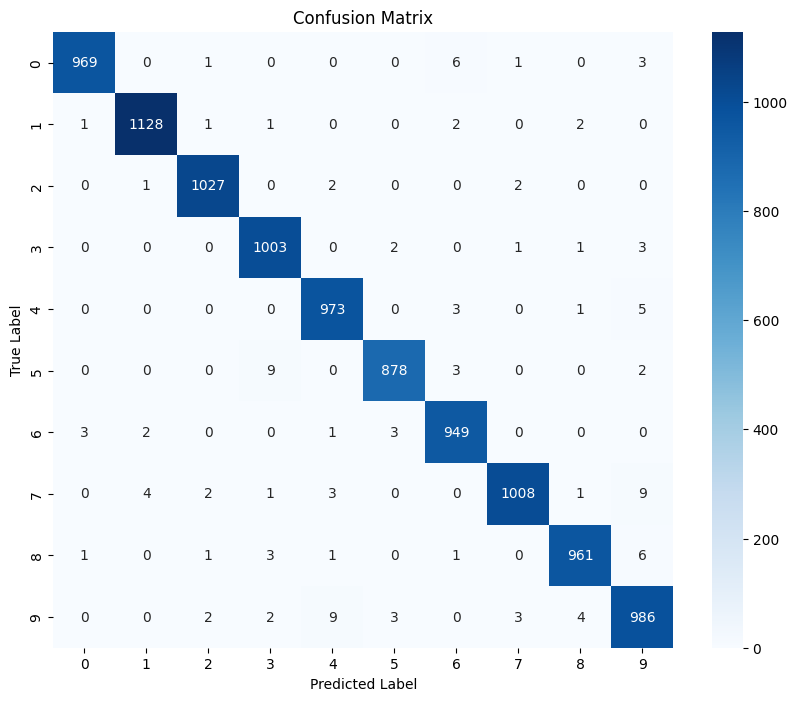

Accuracy: 98.82%
Average AUROC: 0.9999
Class 0 Accuracy: 98.88%
Class 1 Accuracy: 99.38%
Class 2 Accuracy: 99.52%
Class 3 Accuracy: 99.31%
Class 4 Accuracy: 99.08%
Class 5 Accuracy: 98.43%
Class 6 Accuracy: 99.06%
Class 7 Accuracy: 98.05%
Class 8 Accuracy: 98.67%
Class 9 Accuracy: 97.72%
Most predicted class: 1


In [31]:
evaluate_matrix()

In [13]:
#Define skeptic_v7
# Define the model
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 2 * 2, 256)  # Adjusted for 16x16 input
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

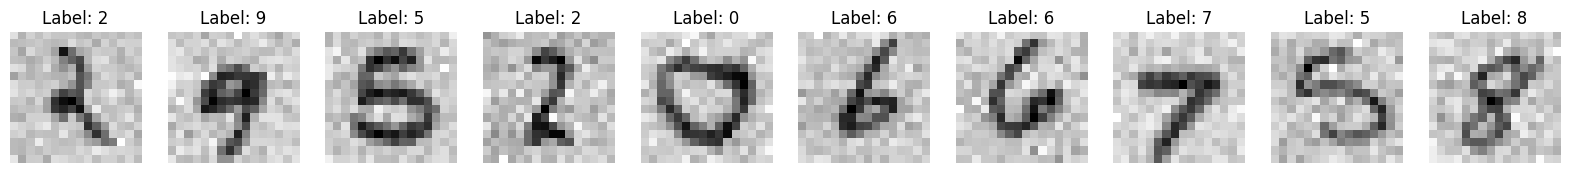

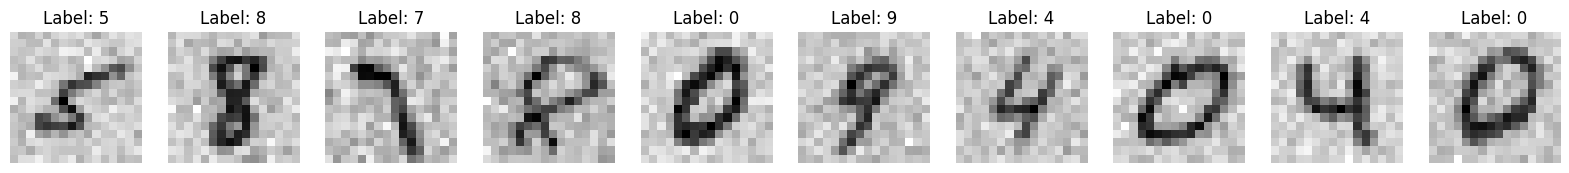

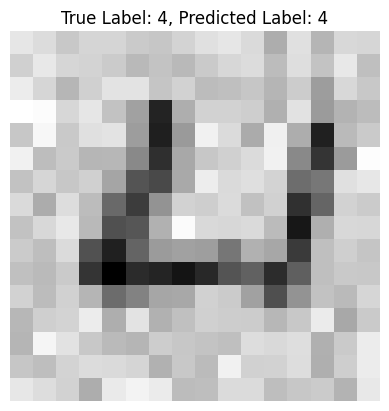

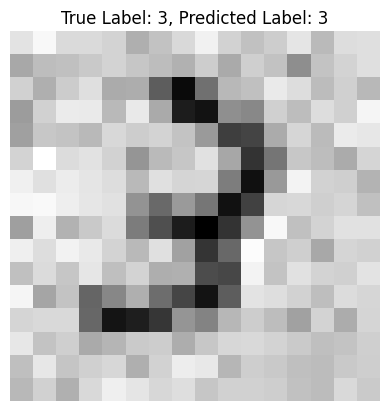

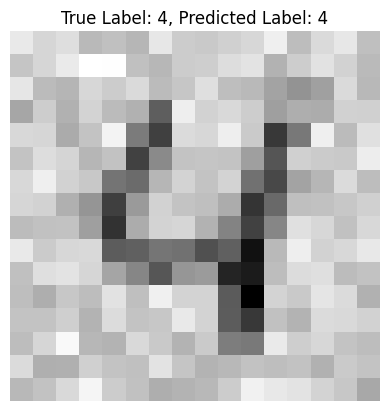

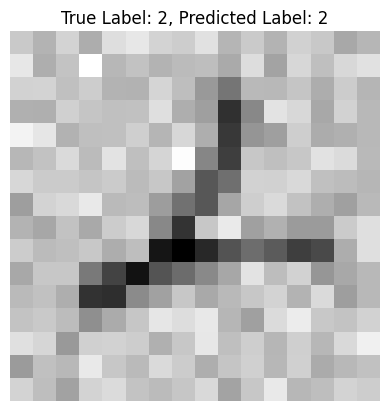

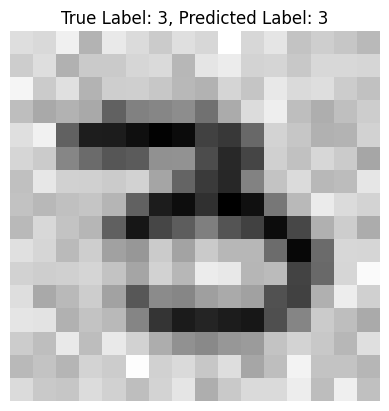

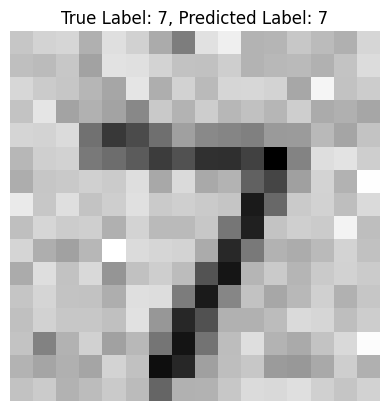

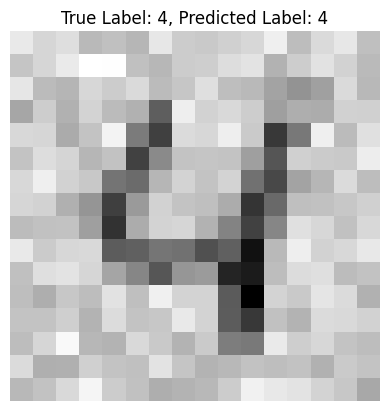

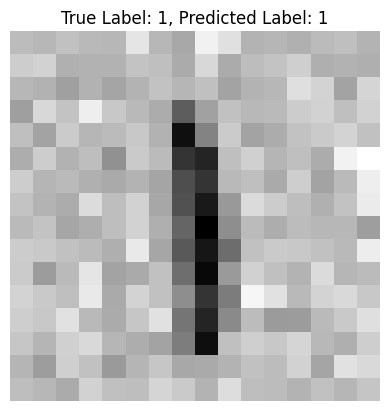

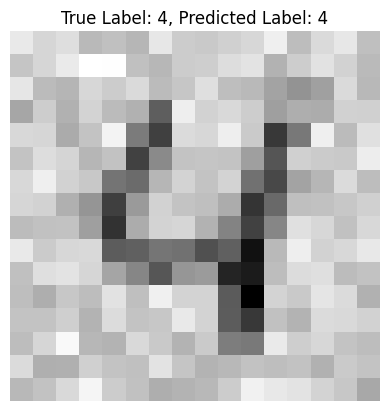

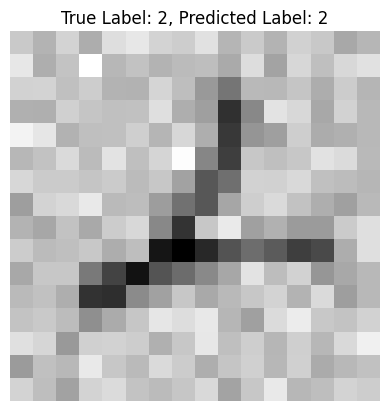

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346019
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.826031
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.696546
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.647274
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.496943
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.475852
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.602607
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.362184
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.346179
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.491540

Test set: Average loss: 0.0059, Accuracy: 8758/10000 (87.58%)
AUROC: 0.9912
Model saved with accuracy: 87.58%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.403084
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.397170
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.298640
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.402600
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.398198
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.357965
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.593894
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.348929
T

In [34]:
#the model has somehow gotten worse - it keeps predicting the same class for all images - let's inspect the transformed data
#visualize_dataset(train_dataset)
#visualize_dataset(test_dataset)

#test the model on some random images
#visualize_predictions()

#the model performs too well during training and too poorly during validation - this is a clear sign of overfitting
#let's try to regularize the model by adding dropout layers

# Data loading and preprocessing - let's increase the noise level to 0.4
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
    transforms.Lambda(lambda x: x + 0.4 * torch.randn_like(x)),  # Add noise
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v7.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training complete')

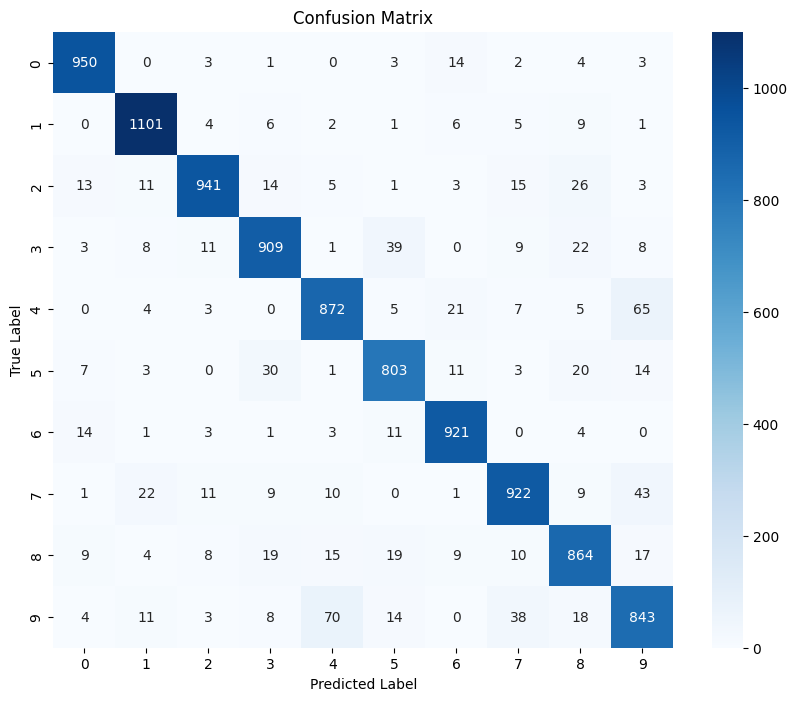

Accuracy: 91.26%
Average AUROC: 0.9954
Class 0 Accuracy: 96.94%
Class 1 Accuracy: 97.00%
Class 2 Accuracy: 91.18%
Class 3 Accuracy: 90.00%
Class 4 Accuracy: 88.80%
Class 5 Accuracy: 90.02%
Class 6 Accuracy: 96.14%
Class 7 Accuracy: 89.69%
Class 8 Accuracy: 88.71%
Class 9 Accuracy: 83.55%
Most predicted class: 1


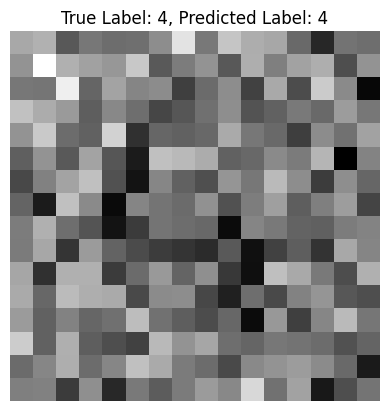

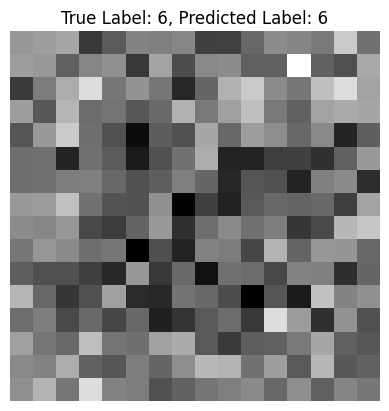

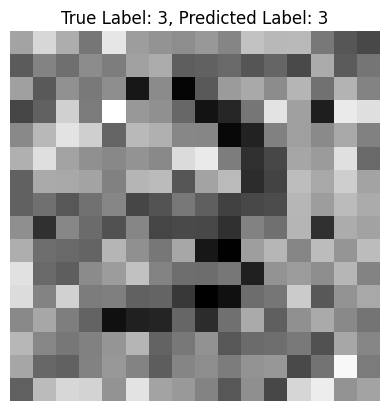

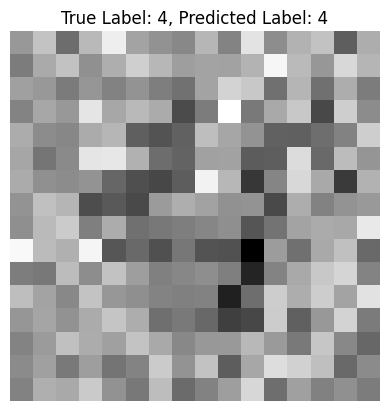

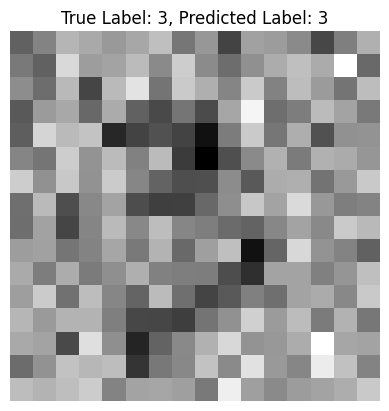

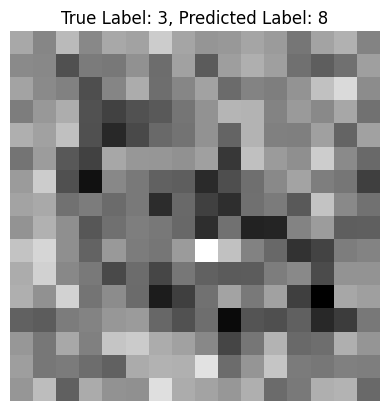

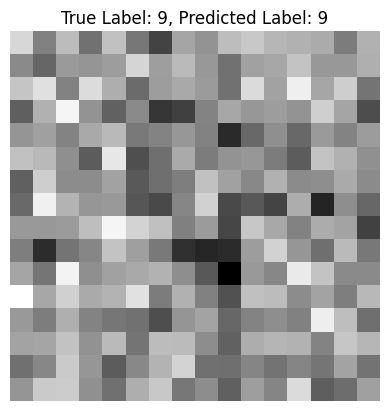

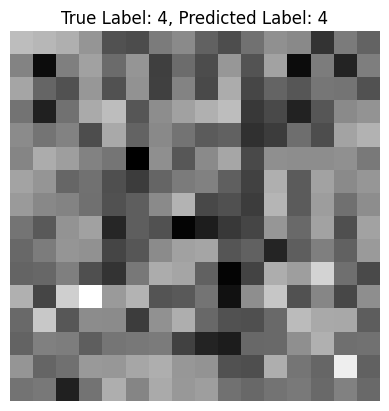

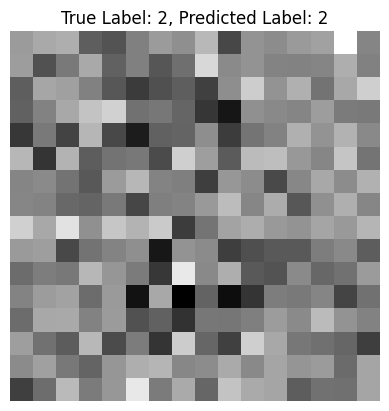

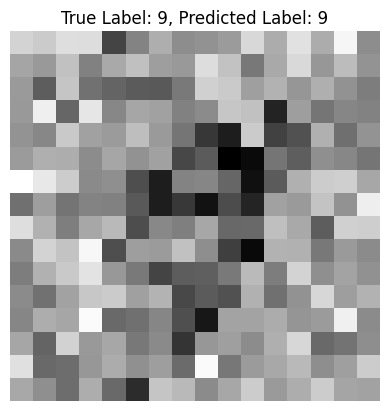

In [35]:
# Evaluate the model and quick test on random images
evaluate_matrix()
visualize_predictions()

this is sus af - not even I can tell these images apart - the model seems to be cheating somehow

In [4]:
#skeptic_v8 spec
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 2 * 2, 256)  # Adjusted for 16x16 input
        self.fc2 = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)

        return x

In [36]:
#the model is still overfitting - let's try to add more dropout layers and reduce noise to 0.3
# Define the model
    
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert colors
    transforms.Lambda(lambda x: x + 0.3 * torch.randn_like(x)),  # Add noise
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v8.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training complete')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349586
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.421721
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.261407
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.329423
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.095068
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.100226
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.964035
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.959033
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.263646
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.891600

Test set: Average loss: 0.0048, Accuracy: 9138/10000 (91.38%)
AUROC: 0.9955
Model saved with accuracy: 91.38%
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.143993
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.290099
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.044904
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.359142
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.093859
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.797404
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.117840
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.035390
T

In [ ]:
#we adjusted in the wrong direction, somehow the model has gotten back into the habit of predicting
#8 for everything but just with lower confidence

In [38]:
#last shot before I go to uni for the day

# Define the model - removed a convolutional layer and reduced filters
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data loading and preprocessing - more agrressive data augmentation
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),
    transforms.Lambda(lambda x: x + 0.4 * torch.randn_like(x)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization - adding weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# Training loop - added an early stop to prevent overfitting
num_epochs = 20
patience = 5
best_accuracy = 0
no_improve = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    scheduler.step(accuracy)  # Update learning rate
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v9.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            print("Early stopping")
            break

print('Training complete')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368607
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.095112
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.854249
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.787233
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.564636
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.750946
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.475460
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.655217
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.548980
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.559133

Test set: Average loss: 0.0214, Accuracy: 5439/10000 (54.39%)
AUROC: 0.8965
Model saved with accuracy: 54.39%
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.546239
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.643037
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.273982
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.469536
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.365181
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.202084
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.440183
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.568535
T

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import zipfile
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F


def load_experimental_data(test_digits_folder, participant_number):
    zip_filename = f'experiment_results_participant{participant_number}.zip'
    zip_filepath = os.path.join(test_digits_folder, zip_filename)
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if filename.endswith('.png'):
                with zip_ref.open(filename) as file:
                    img = Image.open(file).convert('L')  # Convert to grayscale
                    img_tensor = transform(img)
                    
                    if 'composite' in filename:
                        digit = int(filename.split('_')[0])
                        test_images.append(img_tensor)
                        test_labels.append(digit)
                    else:
                        digit = int(filename.split('_')[0])
                        train_images.append(img_tensor)
                        train_labels.append(digit)
    
    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels))


class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]



def fine_tune(model, train_loader, test_loader, optimizer, criterion, num_epochs=5, participant_number=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        model.train()
        for batch_images, batch_labels in train_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_images, batch_labels in test_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                outputs = model(batch_images)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%')
        
        # Save the model if it's the best so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            if participant_number is not None:
                model_name = f'skeptic_v7_participant{participant_number}_finetuned.pth'
            else:
                model_name = 'skeptic_v7_finetuned.pth'
            torch.save(model.state_dict(), model_name)
            print(f'Fine-tuned model saved as {model_name} with accuracy: {best_accuracy:.2f}%')

    return model

In [10]:
# Usage example:
participant_number = 41
train_images, train_labels, test_images, test_labels = load_experimental_data('test_digits', participant_number)

train_dataset = ExperimentalDataset(train_images, train_labels)
test_dataset = ExperimentalDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Assuming you have your model and optimizer defined
model = NoisyDigitClassifier()  # Your model class
model.load_state_dict(torch.load('saved_models/skeptic_v7.pth'))  # Load the pre-trained model
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()

# Fine-tune the model
fine_tuned_model = fine_tune(model, train_loader, test_loader, optimizer, criterion, num_epochs=5, participant_number=participant_number)

C:\Users\saith\AppData\Local\Temp\ipykernel_20076\1314179863.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/skeptic_v7.pt

Epoch 1/5, Test Accuracy: 10.00%
Fine-tuned model saved as skeptic_v7_participant41_finetuned.pth with accuracy: 10.00%
Epoch 2/5, Test Accuracy: 30.00%
Fine-tuned model saved as skeptic_v7_participant41_finetuned.pth with accuracy: 30.00%
Epoch 3/5, Test Accuracy: 30.00%
Epoch 4/5, Test Accuracy: 40.00%
Fine-tuned model saved as skeptic_v7_participant41_finetuned.pth with accuracy: 40.00%
Epoch 5/5, Test Accuracy: 40.00%


from here on we need to slow down and focus, we are going to define a final model, so that we can train 20 of them. Let's keep most of the model structure, but change the transformations a little bit

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import zipfile
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import random

In [9]:
# Define the model - kept the same as before
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data loading and preprocessing - randomly apply color inversion
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x if random.random() < 0.5 else x),
    transforms.Lambda(lambda x: x + 0.4 * torch.randn_like(x)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisyDigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# Training loop - increased epochs and added early stopping
num_epochs = 50
patience = 10
best_accuracy = 0
no_improve = 0

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy, auroc = evaluate(model, device, test_loader)
    
    scheduler.step(accuracy)  # Update learning rate
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'skeptic_v10.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            print("Early stopping")
            break

print('Training complete')

# Create 20 randomly initialized models and save them
for i in range(ord('a'), ord('u')):
    model = NoisyDigitClassifier().to(device)
    torch.save(model.state_dict(), f'skeptic_v10_{chr(i)}.pth')
    print(f'Model {chr(i)} saved.')

# Evaluate and rank the performance of all 20 models
model_performance = []
for i in range(ord('a'), ord('u')):
    model = NoisyDigitClassifier().to(device)
    model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth'))
    accuracy, auroc = evaluate(model, device, test_loader)
    model_performance.append((chr(i), accuracy, auroc))

model_performance.sort(key=lambda x: x[1], reverse=True)

print("Performance ranking of all 20 models:")
for model, accuracy, auroc in model_performance:
    print(f"Model {model}: Accuracy={accuracy:.2f}%, AUROC={auroc:.2f}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338506
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.301522
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.247740
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.098498
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.262880
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.118294
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.998683
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.061811
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.984186
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.849262

Test set: Average loss: 0.0287, Accuracy: 3700/10000 (37.00%)
AUROC: 0.8045
Model saved with accuracy: 37.00%
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.979447
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.919487
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.917467
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.985022
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.956941
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.883416
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.867451
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.703613
T

C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0364, Accuracy: 986/10000 (9.86%)
AUROC: 0.5009


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0365, Accuracy: 1009/10000 (10.09%)
AUROC: 0.4955


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0364, Accuracy: 894/10000 (8.94%)
AUROC: 0.4949


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1047/10000 (10.47%)
AUROC: 0.4912


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 982/10000 (9.82%)
AUROC: 0.5066


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 921/10000 (9.21%)
AUROC: 0.5109


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0364, Accuracy: 1003/10000 (10.03%)
AUROC: 0.5002


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0365, Accuracy: 954/10000 (9.54%)
AUROC: 0.4829


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 995/10000 (9.95%)
AUROC: 0.4932


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0364, Accuracy: 1015/10000 (10.15%)
AUROC: 0.5034


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1009/10000 (10.09%)
AUROC: 0.5104


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0365, Accuracy: 969/10000 (9.69%)
AUROC: 0.4922


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 973/10000 (9.73%)
AUROC: 0.4994


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1029/10000 (10.29%)
AUROC: 0.5040


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1053/10000 (10.53%)
AUROC: 0.5109


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1053/10000 (10.53%)
AUROC: 0.4959


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0367, Accuracy: 951/10000 (9.51%)
AUROC: 0.4990


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0364, Accuracy: 992/10000 (9.92%)
AUROC: 0.4912


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 975/10000 (9.75%)
AUROC: 0.5053


C:\Users\Sai\AppData\Local\Temp\ipykernel_36364\4249363194.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'skeptic_v10_{chr(i)}.pth')


Test set: Average loss: 0.0363, Accuracy: 1026/10000 (10.26%)
AUROC: 0.5067
Performance ranking of all 20 models:
Model o: Accuracy=10.53%, AUROC=0.51
Model p: Accuracy=10.53%, AUROC=0.50
Model d: Accuracy=10.47%, AUROC=0.49
Model n: Accuracy=10.29%, AUROC=0.50
Model t: Accuracy=10.26%, AUROC=0.51
Model j: Accuracy=10.15%, AUROC=0.50
Model b: Accuracy=10.09%, AUROC=0.50
Model k: Accuracy=10.09%, AUROC=0.51
Model g: Accuracy=10.03%, AUROC=0.50
Model i: Accuracy=9.95%, AUROC=0.49
Model r: Accuracy=9.92%, AUROC=0.49
Model a: Accuracy=9.86%, AUROC=0.50
Model e: Accuracy=9.82%, AUROC=0.51
Model s: Accuracy=9.75%, AUROC=0.51
Model m: Accuracy=9.73%, AUROC=0.50
Model l: Accuracy=9.69%, AUROC=0.49
Model h: Accuracy=9.54%, AUROC=0.48
Model q: Accuracy=9.51%, AUROC=0.50
Model f: Accuracy=9.21%, AUROC=0.51
Model c: Accuracy=8.94%, AUROC=0.49


We will need to do try to get a meaningful confusion matrix from the above family of models even though they don't make much sense anymore

In [ ]:
#domain adaptation
# After initial training on MNIST
experimental_loader = DataLoader(experimental_dataset, batch_size=32, shuffle=True)
for epoch in range(5):  # Fine-tune for a few epochs
    train(model, device, experimental_loader, optimizer, epoch)

In [ ]:
#ensemble approach
models = [NoisyDigitClassifier().to(device) for _ in range(5)]
# Train each model separately
predictions = torch.stack([model(x) for model in models]).mean(0)